# Automobile Fuel Efficiency Analysis in R
## Objectives 
* Acquiring automobile fuel efficiency data
* Preparing the R environment
* Importing automobile fuel efficiency data into R
* Exploring and describing fuel efficiency data
* Analyzing automobile fuel efficiency over time

### Metadata

The Office of Energy Efficiency and Renewable Energy of the U.S. Environmental Protection Agency (EPA) provide access to Vehicle Dataset through their [Fuel Economy Site](http://www.fueleconomy.gov). This dataset contains fuel efficiency performance metrics, measured in miles per gallon (MPG) over time, for most makes and models of automobiles available in the U.S. since 1984. In addition to fuel efficiency attributes, this dataset also contains several other attributes of the vehicle listed, thereby providing the opportunity to summarize and group data to determine which makers or models tend to have better fuel efficiency historically and how this has changed over the years.

### Acquiring automobile fuel efficiency data

In [2]:
# URL containing the data file
url<-'http://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip'
# Create a temporary file to save the downloaded file
temp <- tempfile()
# Downloading the data file
download.file(url,temp)
# Unziping the data file and reading it into R 
data <- read.table(unz(temp, "vehicles.csv"),sep=',',header = TRUE)
# Removing the temporary file
unlink(temp)

### Preparing the R environment
To install new packages in a non default location use: 
* install.packages('tidyverse',lib='~/.R_Libs')

To tell R where to look for this packages use:
* .libPaths(c(.libPaths(),'~/.R_Libs'))

In [3]:
# Loading required libraries
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Exploring and describing fuel efficiency data

#### Data Structure
A description of the features can be access [here](https://www.fueleconomy.gov/feg/ws/index.shtml#vehicle)

In [ ]:
str(data)

#### Summary of the data

In [ ]:
summary(data)

We see from the previous output that the year ranges from 1984 to 2021. Looking at the distribution of observations by year it can be observe that the year 2021 only has 3. Therefore, this year is going to be remove from the dataset for posterior analysis.

In [ ]:
table(data$year)

In [4]:
data <- data %>% filter(year<2021)

### Average MPG overall trend over time.
To do this, we will use a technique call split-apply-combine. We will __split__ the dataframe into groups by year, __apply__ the mean function to specific variables, and __combine__ the results into a new data frame. This can be accomplish using the ddply function from the plyr package to take the data, aggregate the observations by year, and then, for each group, compute the mean highway, city, and combine fuel efficiency. The result of this process is then visualize using the ggplot2 Library which is an implementation of the [Grammer of Graphics](https://towardsdatascience.com/a-comprehensive-guide-to-the-grammar-of-graphics-for-effective-visualization-of-multi-dimensional-1f92b4ed4149).

In [ ]:
data %>% 
    plyr::ddply(~year, summarise, avgMPG = mean(comb08), avgHghy = mean(highway08),avgCity = mean(city08)) %>%
    ggplot(aes(year,avgMPG)) + geom_point() + geom_smooth() + xlab("Year") + ylab("Average MPG") + 
    ggtitle("All cars") + theme_bw()

Based on this visualization, one might conclude that there has been a tremendous increase in the fuel economy of cars sold in the last few years. However, this can be a little misleading as there have been more hybrid and non-gasoline vehicles in the later years.

In [ ]:
data %>% 
    select(year,fuelType1,atvType) %>% 
    plyr::ddply(~year,summarise,electrical=sum(fuelType1=='Electricity' | atvType=='Hybrid')) %>% 
    filter(electrical>0) %>% 
    mutate(year=as.factor(year)) %>% 
    ggplot(aes(year,electrical)) + geom_bar(stat = 'identity',fill='lightblue') + theme_bw()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



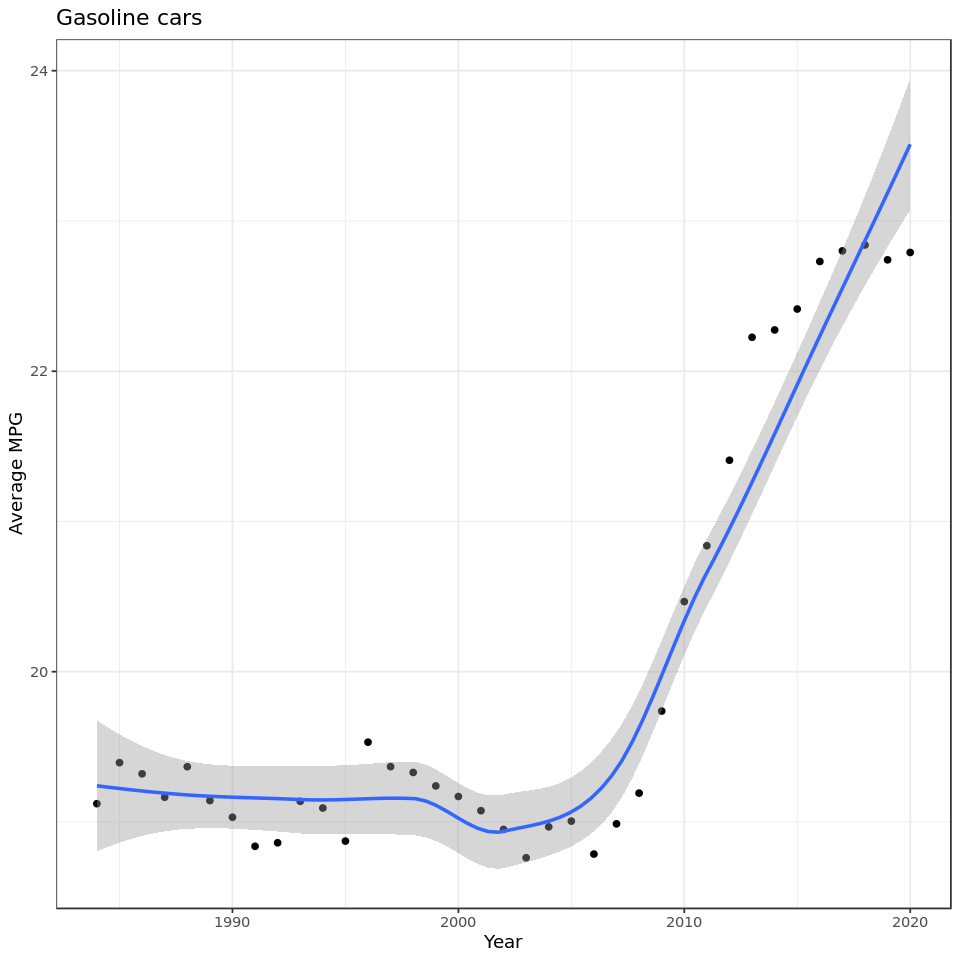

In [11]:
vehicles_non_hybrid <- data %>% filter(grepl('Gasoline',fuelType1) & fuelType2 == "" & atvType!='Hybrid')
vehicles_non_hybrid %>% 
    plyr::ddply(~year, summarise, avgMPG = mean(comb08), avgHghy = mean(highway08),avgCity = mean(city08)) %>%
    ggplot(aes(year,avgMPG)) + geom_point() + geom_smooth() + xlab("Year") + ylab("Average MPG") + 
    ggtitle("Gasoline cars") + theme_bw()

This visualization shows that there is still a marked rise in the average miles per gallon even after eliminating hybrids. The next question that we can ask is whether there have been fewer cars with large engines built more recently? If this is true, it could explain the increase in average miles per gallon. First, let's verify that larger engine cars have poorer miles per gallon.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


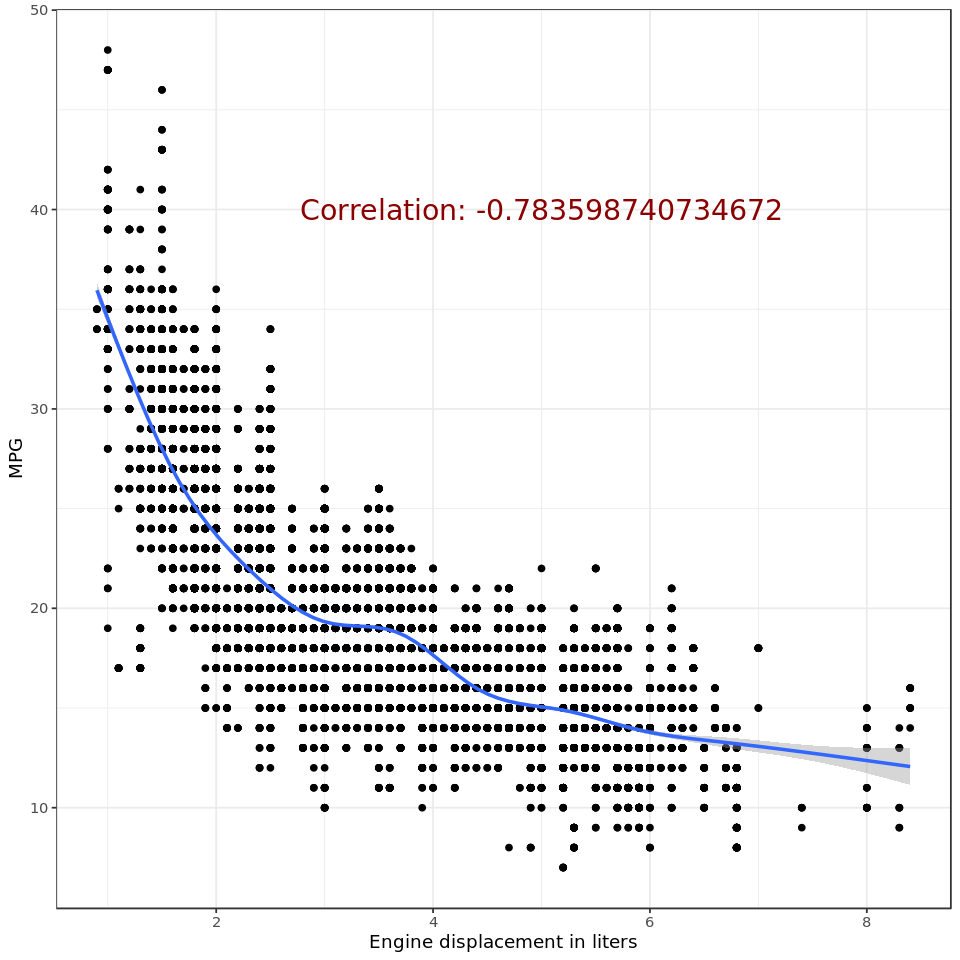

In [13]:
vehicles_non_hybrid %>% 
    ggplot(aes(displ, comb08)) + geom_point() + geom_smooth() + 
    xlab('Engine displacement in liters') + ylab('MPG') + 
    annotate('text',x=5,y=40,
             label=paste('Correlation:',cor(vehicles_non_hybrid$comb08,vehicles_non_hybrid$displ,use='complete.obs')),
             colour='darkred',size=6
            ) + theme_bw()

Now, let's see whether more small cars were made in later years, which can explain the drastic increase in fuel efficiency.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


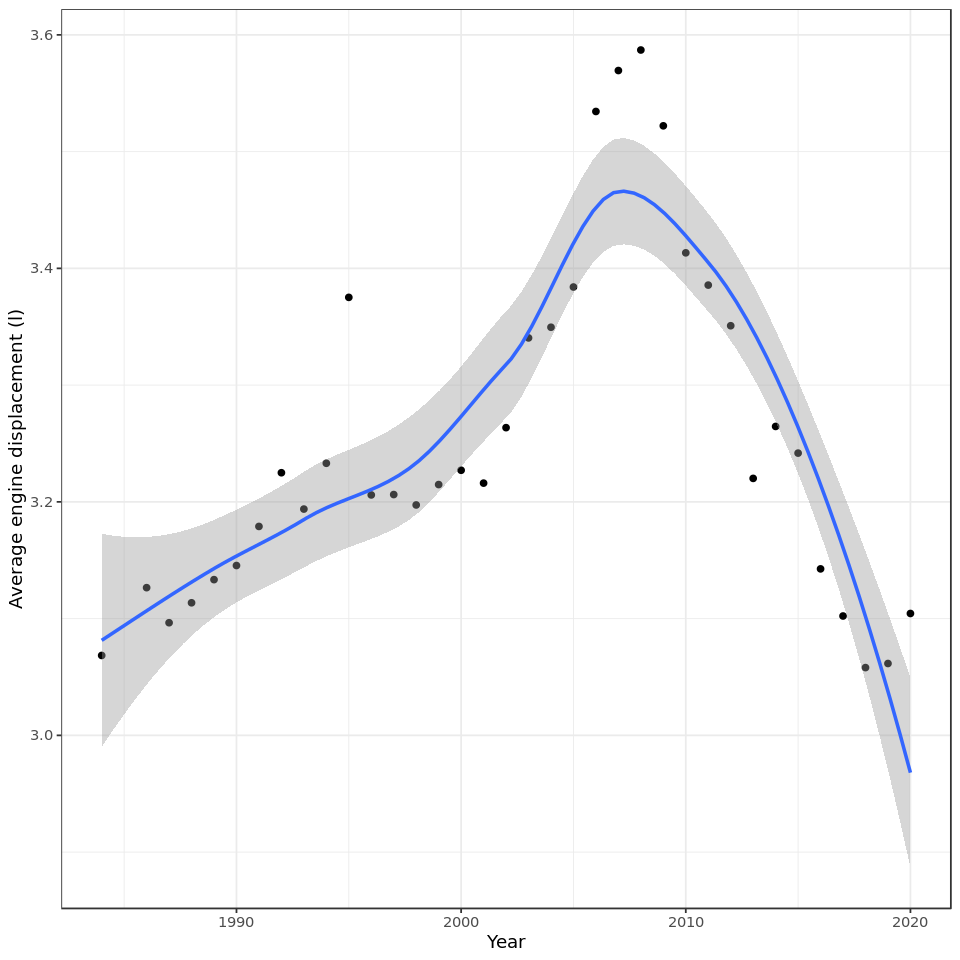

In [14]:
vehicles_non_hybrid %>% 
    plyr::ddply(~year, summarise, avgDispl = mean(displ)) %>%
    ggplot(aes(year, avgDispl)) + geom_point() + geom_smooth() + 
    xlab("Year") + ylab("Average engine displacement (l)") + theme_bw()

From the preceding figure,it can be observed the average engine displacement has decreased substantially since 2008. To get a better sense of the impact this might have had on fuel efficiency, we can put both MPG and displacement by year on the same graph. To do this, we need to reshape the dataset to convert it from the wide format to the long format using the __melt__ function of the package reshape2.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


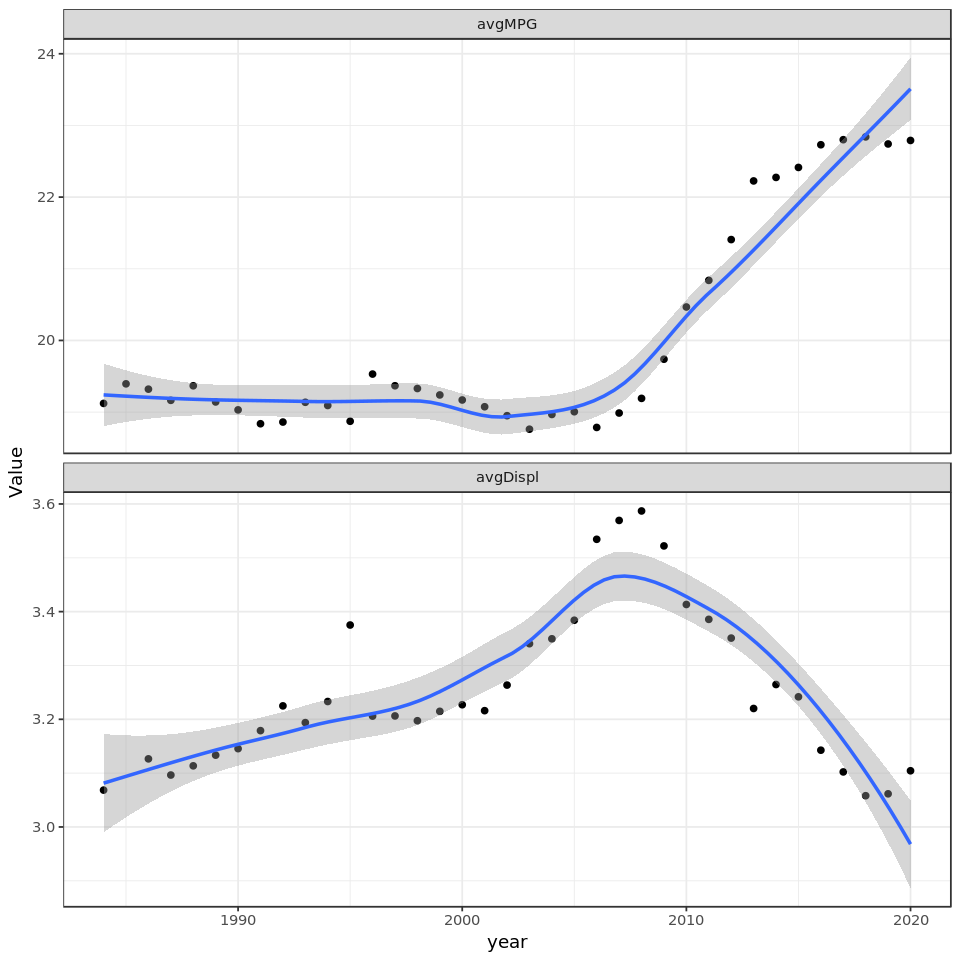

In [15]:
vehicles_non_hybrid %>%
    plyr::ddply(~year, summarise, avgMPG = mean(comb08), avgDispl = mean(displ)) %>%
    reshape2::melt(id = "year",value.name = 'Value',variable.name = 'Atribute') %>%
    ggplot(aes(year,Value)) + geom_point() + geom_smooth() + theme_bw() +
    facet_wrap(~Atribute,ncol = 1,scales='free_y')

From this visulazation, we can see the following:
* Engine sizes have generally increased until 2008, with a sudden increase in large cars between 2006 and 2008.
* Since 2009, there has been a decrease in the average car size, which partially explains the increase in fuel efficiency.
* Until 2005, there was an increase in the average car size, but the fuel efficiency remained roughly constant. This seems to indicate that engine efficiency has increased over the years.
* The years 2006–2008 are interesting. Though the average engine size increased quite suddenly, the MPG remained roughly the same as in previous years. This seeming discrepancy might require more investigation.

Now, let's see how makes and models of cars inform us about fuel efficiency over time. First, look at the frequency of makes and models of cars available in the U.S., concentrating on 4-cylinder cars.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



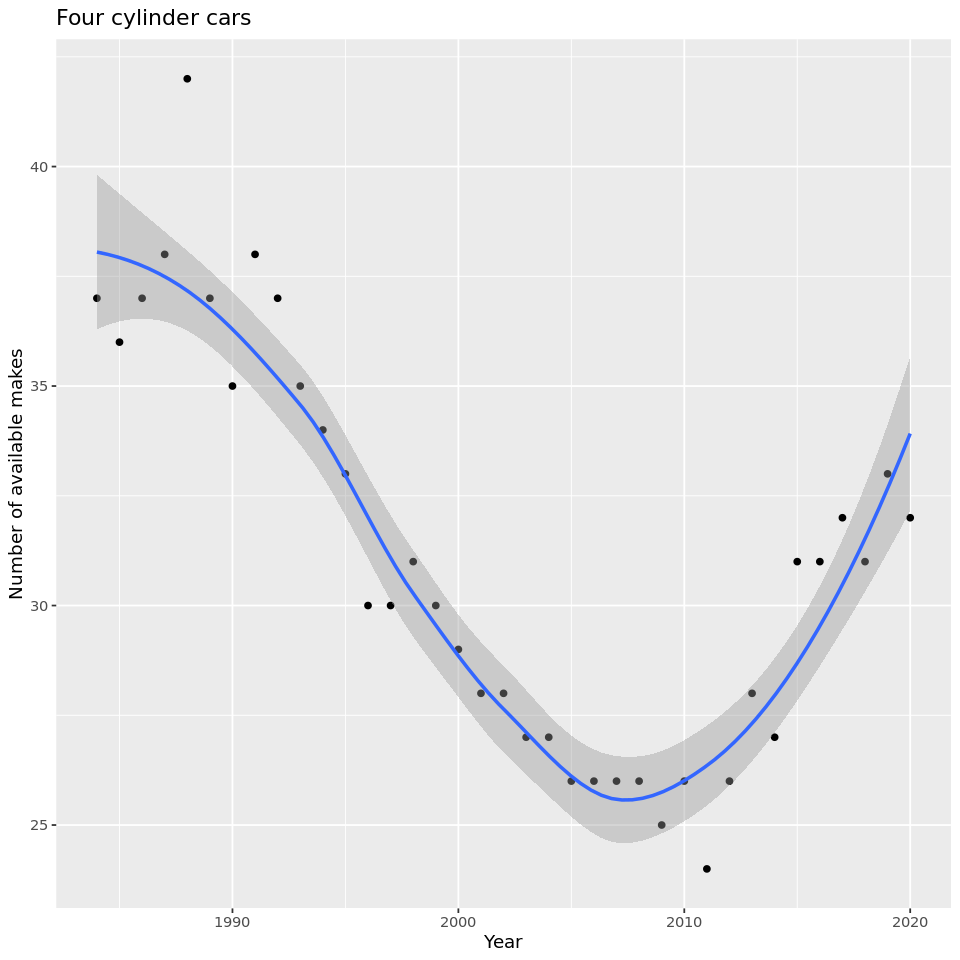

In [21]:
vehicles_non_hybrid_4 <- vehicles_non_hybrid %>% filter(cylinders == 4)
vehicles_non_hybrid_4 %>% 
    plyr::ddply(~year,summarise,numberOfMakes = length(unique(make))) %>%
    ggplot(aes(x=year,y=numberOfMakes)) + geom_point() + xlab('Year') + ylab('Number of available makes') +
        ggtitle('Four cylinder cars') + geom_smooth()

We can see in the preceding graph that there has been a decline in the number of makes with 4-cylinder engines available since 1980. Can we look at the makes that have been available every year in this dataset?

In [24]:
uniqMakes <- vehicles_non_hybrid_4 %>% plyr::dlply(~year, function(x) unique(x$make))
commonMakes <- Reduce(intersect, uniqMakes)
commonMakes

[1] "Ford"       "Honda"      "Toyota"     "Volkswagen" "Chevrolet" 
 [6] "Nissan"     "Dodge"      "Mazda"      "Mitsubishi" "Subaru"    
[11] "Jeep"

Let see how these car manufacturers' models have performed over time.

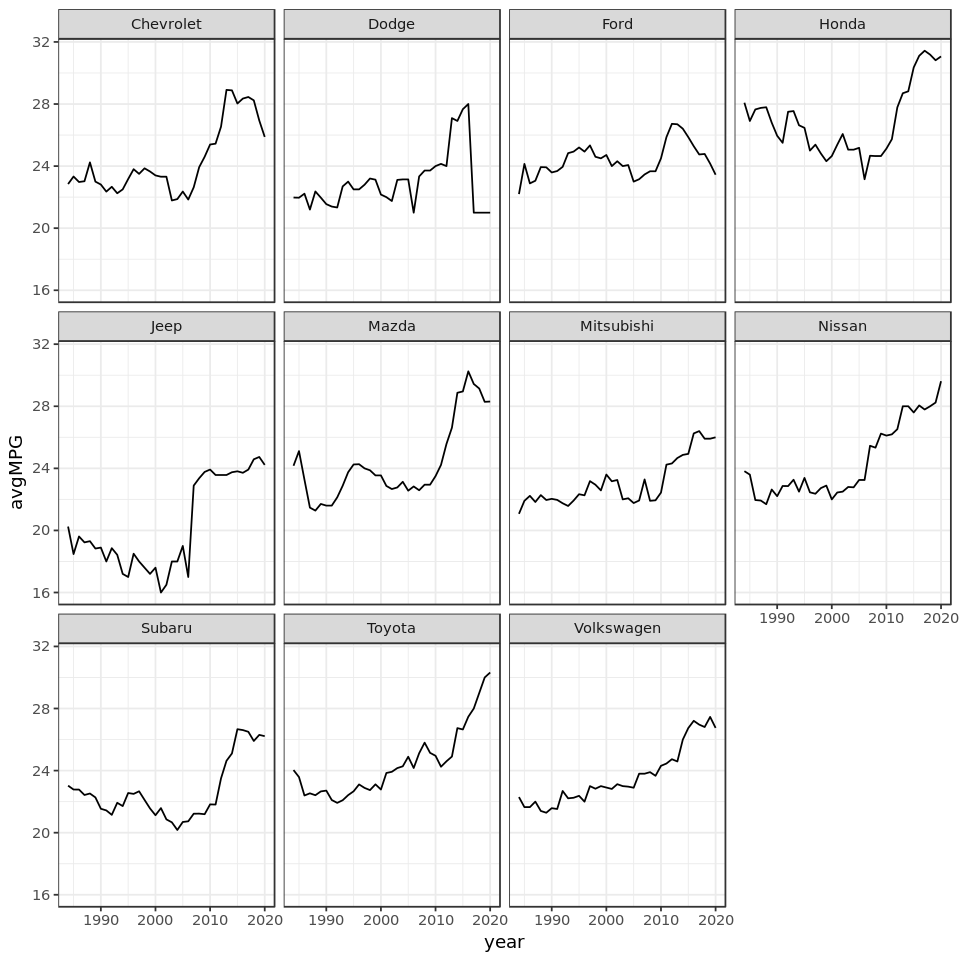

In [27]:
vehicles_non_hybrid_4 %>%
    filter(make %in% commonMakes) %>%
    plyr::ddply(~year + make, summarise, avgMPG = mean(comb08)) %>%
    ggplot(aes(year, avgMPG)) + geom_line() + facet_wrap(~make, nrow = 3) + theme_bw()